In [316]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.interpolate import interp1d

# plotting
import matplotlib.pyplot as plt
from ipywidgets import interact
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# fitting
from sklearn.metrics import r2_score
from scipy.optimize import minimize
from functools import partial
import multiprocess as mp
import matplotlib.patches as mpatches

# custom
from reflectance import plotting, spectrum_utils, optimisation_pipeline, file_ops

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pipeline

In [345]:
config_dict = {
    "processing": 
    {
        'aop_group_num': 1,
        'nir_wavelengths': [750, 1100],
        'sensor_range': [450, 690],
        'endmember_dimensionality_reduction': 'mean',
        'endmember_normalisation': False,
        'endmember_class_schema': 'individual',
        'spectra_normalisation': False,
        'endmember_source': 'data/AOP_models/Rb_model_single_coefficient.txt'
    },
    "simulation":
    {
        "type": "spread",
        "N": 10,
        "Rb_vals": [0,1,0],
        "n_depths": 10,
        "depth_lims": [0, 10],
        "n_ks": 10,
        "k_lims": [0, 0.4],
        "n_bbs": 10,
        "bb_lims": [0.01, 0.03],
        "n_noise_levels": 10,
        "noise_lims": [0.001, 0],
        "noise_ind": 0
    },
    "fitting":
    {
        'objective_fn': 'og_r2',
        'Rb_init': 0,
        'bb_bounds': (0, 0.41123),
        'Kd_bounds': (0.01688, 3.17231),
        'H_bounds': (0, 30),
        'endmember_bounds': (0, 1),
        'solver': 'L-BFGS-B',
        'tol': 1e-12
    }}
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)

cfg = file_ops.RunOptPipeConfig(config_dict)
g_cfg = glob_cfg

pipe = optimisation_pipeline.OptPipe(g_cfg, cfg)
fit_results = pipe.run()

Fitting spectra:   0%|          | 0/1938 [00:00<?, ?it/s]

RunOptPipeConfig(aop_group_num=1, nir_wavelengths=[750, 1100], sensor_range=[450, 690], endmember_source=PosixPath('/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/data/AOP_models/Rb_model_single_coefficient.txt'), endmember_dimensionality_reduction='mean', endmember_normalisation=False, endmember_class_schema='individual', spectra_normalisation=False, objective_fn='og_r2', bb_bounds=(0, 0.41123), Kd_bounds=(0.01688, 3.17231), H_bounds=(0, 30), simulation={'type': 'spread', 'N': 10, 'Rb_vals': [0, 1, 0], 'n_depths': 10, 'depth_lims': [0, 10], 'n_ks': 10, 'k_lims': [0, 0.4], 'n_bbs': 10, 'bb_lims': [0.01, 0.03], 'n_noise_levels': 10, 'noise_lims': [0.001, 0], 'noise_ind': 0}, solver='L-BFGS-B', tol=1e-12)


In [346]:
fit_results.fitted_params

,bb,K,H,Rb0
0,0.411230,0.783094,7.672585,0.14819
1,0.411230,0.772864,7.534749,0.154254
2,0.411230,0.522241,3.18362,1.0
3,0.411230,0.799533,7.954576,0.13238
4,0.411230,0.771873,7.869133,0.129065
...,...,...,...,...
1933,0.052994,0.266569,30.0,0.206898
1934,0.052954,0.255275,19.273721,0.885906
1935,0.050248,0.15205,11.327806,1.0
1936,0.050804,0.234923,13.867147,0.978209


In [347]:
fitted_df = fit_results.fitted_spectra
wvs = fitted_df.columns
lim_prism_spectra = preprocess_prism_spectra(spectrum_utils.load_spectra(), nir_wavelengths = [750,1100], sensor_range = [450,690]).loc[:len(fitted_df)-1, :]

recorded r2: 0.9403400132790244 sa: 0.057912785276511024


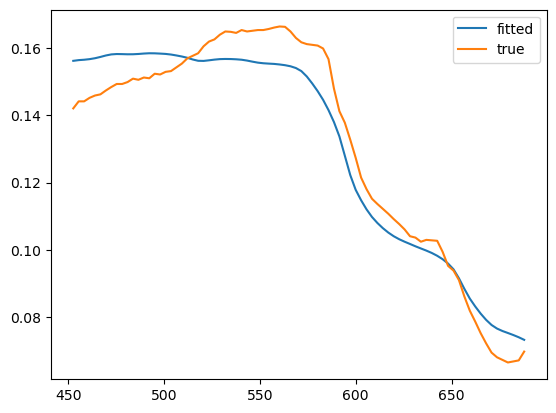

In [348]:
# plot fitted spectra
i = 10
true_spectrum = lim_prism_spectra.iloc[i]
fitted_spectrum = fit_results.fitted_spectra.iloc[i]

plt.plot(wvs, fitted_spectrum, label='fitted')
plt.plot(wvs, true_spectrum, label='true')
plt.legend()
from sklearn.metrics import r2_score
# print("calculated r2:", r2_score(lim_prism_spectra.iloc[i], fit_results.fitted_spectra.iloc[i]))
print("recorded r2:", fit_results.metrics.r2.iloc[i], "sa:", fit_results.metrics.spectral_angle.iloc[i])

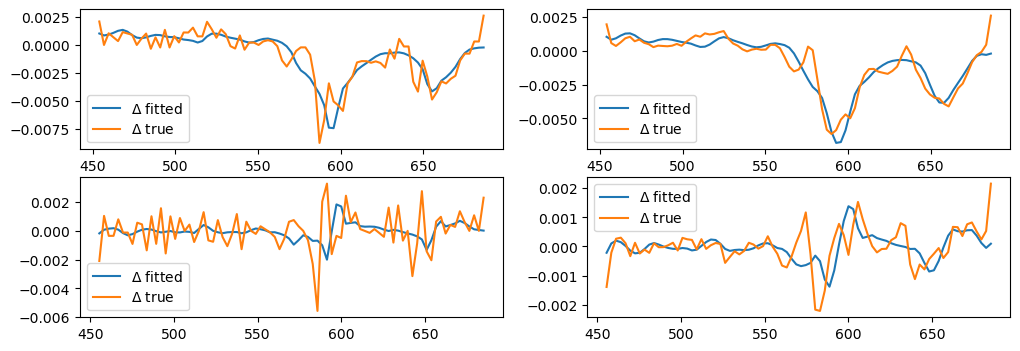

In [338]:
# SMOOTHING AND DERIVATIVES
from scipy.signal import savgol_filter

window_length = 11
order = 5

# differentiate spectra
diff_fitted = np.diff(fitted_spectrum)
diff_true = np.diff(true_spectrum)
smooth_diff_fitted = savgol_filter(diff_fitted, window_length, polyorder=order)
smooth_diff_true = savgol_filter(diff_true, window_length, polyorder=order)

d1_wvs = (wvs[1:] + wvs[:-1]) / 2
d2_wvs = (d1_wvs[1:] + d1_wvs[:-1]) / 2

fig, ax = plt.subplots(2, 2, figsize=(12, 4))


ax[0,0].plot(d1_wvs, diff_fitted, label='$\\Delta$ fitted')
ax[0,0].plot(d1_wvs, diff_true, label='$\\Delta$ true')
ax[1,0].plot(d2_wvs, np.diff(diff_fitted), label='$\\Delta$ fitted')
ax[1,0].plot(d2_wvs, np.diff(diff_true), label='$\\Delta$ true')

ax[0,1].plot(d1_wvs, smooth_diff_fitted, label='$\\Delta$ fitted')
ax[0,1].plot(d1_wvs, smooth_diff_true, label='$\\Delta$ true')
ax[1,1].plot(d2_wvs, np.diff(smooth_diff_fitted), label='$\\Delta$ fitted')
ax[1,1].plot(d2_wvs, np.diff(smooth_diff_true), label='$\\Delta$ true')

[ax_.legend() for ax_ in ax.flatten()];

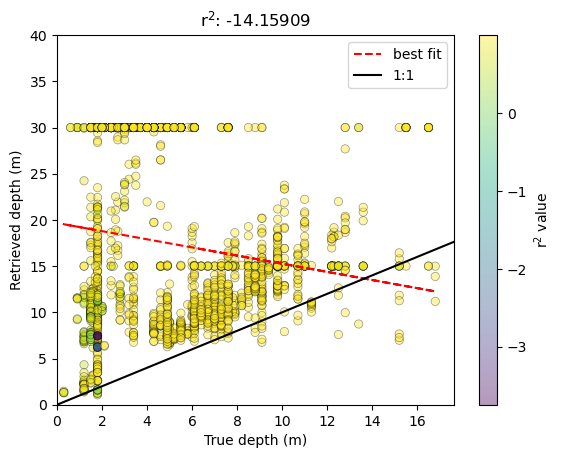

In [349]:
fits = pd.concat([fit_results.fitted_params, fit_results.metrics], axis=1)
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data_v2.csv")

fig, ax = plt.subplots()
ma = ax.scatter(validation_data.Depth[:len(fits)], fits.H, alpha=0.4, c=fits.r2, edgecolor='k', lw=0.5)

# calculate fits
p = np.polyfit(validation_data.Depth[:len(fits)], fits.H.astype(float), 1)
pred = np.polyval(p, validation_data.Depth[:len(fits)])
r2 = r2_score(validation_data.Depth[:len(fits)], pred)
ax.plot(validation_data.Depth[:len(fits)], pred, color='r', ls='--', label="best fit")
# formatting
ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=40)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='k', label='1:1')
ax.set_title(f"r$^2$: {r2:.5f}")
ax.set_xlabel("True depth (m)")
ax.set_ylabel("Retrieved depth (m)")
# ax.set_aspect('equal')
fig.colorbar(ma, label="r$^2$ value")
ax.legend()


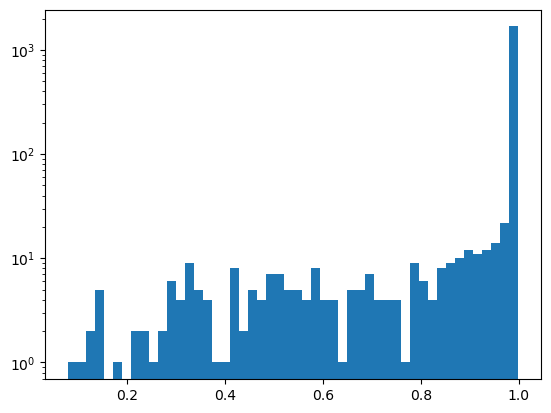

In [240]:
plt.hist(fits.r2, bins=50)
plt.yscale('log')

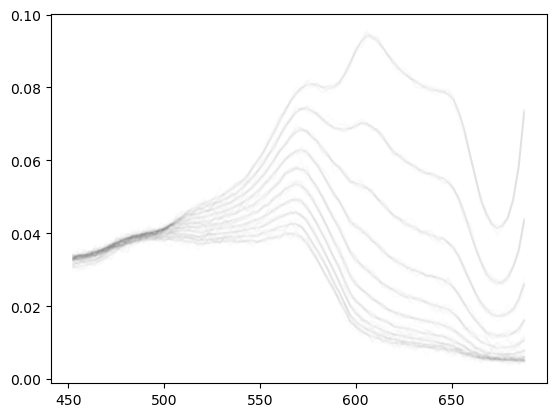

In [28]:
# view fits
test_spectra = pd.read_csv(file_ops.RESULTS_DIR_FP / "fits/sim_spectra_1.csv")
wvs = test_spectra.columns[4:].astype(float)
plt.plot(wvs, test_spectra.iloc[:,4:].values.T, color='k', alpha=0.01);

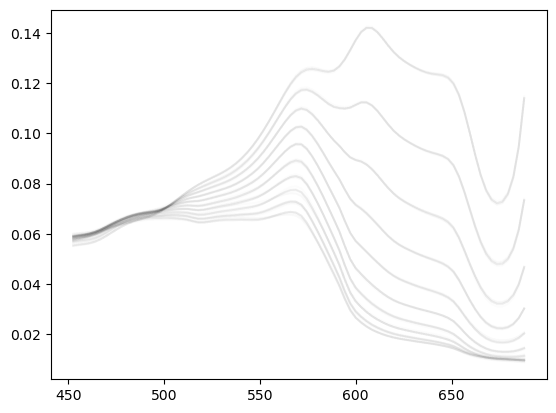

In [29]:
test_fits = pd.read_csv(file_ops.RESULTS_DIR_FP / "fits/fit_results_1.csv", skiprows=1)
wvs = test_fits.iloc[:,6:-2].columns.astype('float')
plt.plot(wvs, test_fits.iloc[:,6:-2].values.T, color='k', alpha=0.01);

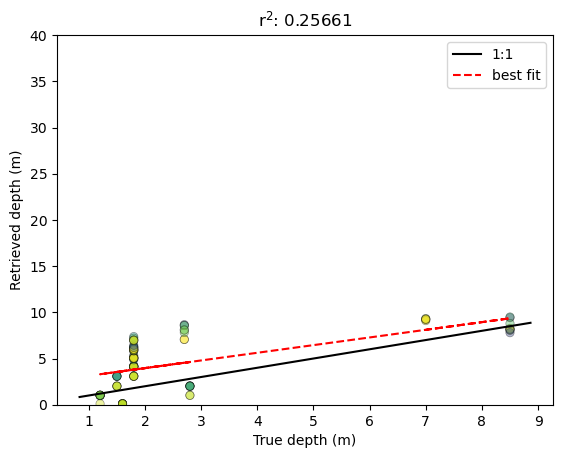

In [35]:
fits = test_fits
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data_v2.csv")


fig, ax = plt.subplots()
ma = ax.scatter(validation_data.Depth[:len(fits)], fits.H, alpha=0.4, c=fits.r2, edgecolor='k', lw=0.5)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='k', label='1:1')

# calculate fits
p = np.polyfit(validation_data.Depth[:len(fits)], fits.H, 1)
pred = np.polyval(p, validation_data.Depth[:len(fits)])
r2 = r2_score(validation_data.Depth[:len(fits)], pred)
ax.plot(validation_data.Depth[:len(fits)], pred, color='r', ls='--', label="best fit")
# formatting
ax.set_title(f"r$^2$: {r2:.5f}")
ax.set_xlabel("True depth (m)")
ax.set_ylabel("Retrieved depth (m)")
ax.set_ylim(0,40)
# fig.colorbar(ma, label="r$^2$ value")
ax.legend()


In [37]:
# Create a scatter plot of retrieved vs actual depth
scatter = go.Scatter(
    x=validation_data.Depth[:len(fits)],
    y=fits.H,
    mode='markers',
    marker=dict(
        size=10,
        color=fits.r2,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="whole-spectrum r<sup>2</sup> value"),
        line=dict(width=0.5, color='#000000'),
        opacity=0.5,
        # assign hover labels the respective values in validation_data
      ),
        name='Data points',
        hovertext=[f"K: {K:.2f}, bb: {bb:.2f}, r<sup>2</sup>: {r2:.5f}, sa: {sa:.5f}, sample: {i}" for K, bb, r2, sa, i in zip(fits.K, fits.bb, fits.r2, fits.spectral_angle, fits.index)],
    # hoverinfo="text"
)

p = np.polyfit(validation_data.Depth[:len(fits)], fits.H, 1)
pred = np.polyval(p, validation_data.Depth[:len(fits)])
# THIS LOOKS WRONG
best_fit_line = go.Scatter(
    x=validation_data.Depth[:len(fits)],
    y=pred,
    mode='lines',
    line=dict(color='red', dash='dash'),
    name=f"Best fit: {p[0]:.2f}x + {p[1]:.2f}",
)
one_to_one_line = go.Scatter(
    x=[min(validation_data.Depth[:len(fits)]), max(validation_data.Depth[:len(fits)])],
    y=[min(validation_data.Depth[:len(fits)]), max(validation_data.Depth[:len(fits)])],
    mode='lines',
    line=dict(color='black'),
    name='1:1'
)

plot = True
if plot:
    fig = make_subplots()
    fig.add_trace(scatter)
    fig.add_trace(best_fit_line)
    fig.add_trace(one_to_one_line)

    # Update layout
    fig.update_layout(
        title=f"r<sup>2</sup>: {r2_score(validation_data.Depth[:len(fits)], fits.H):.5f}",
        xaxis_title="True depth (m)",
        yaxis_title="Retrieved depth (m)",
        xaxis=dict(range=[min(validation_data.Depth[:len(fits)]), max(validation_data.Depth[:len(fits)])], scaleanchor='y', scaleratio=1),
        yaxis=dict(range=[min(validation_data.Depth[:len(fits)]), max(validation_data.Depth[:len(fits)])], scaleanchor='x', scaleratio=1),
        legend=dict(x=0.02, y=0.98),   
    )

    fig.update_yaxes(
        scaleanchor='x',
        scaleratio=1,
    )

    # show the figure
    fig.show()

In [41]:
fits.iloc[:,6:-2].columns.astype('float')

Index([452.6427748, 455.4750562, 458.3073937, 461.1397875, 463.9722376,
       466.8047438, 469.6373064, 472.4699251, 475.3026001, 478.1353314,
       480.9681188, 483.8009626, 486.6338625, 489.4668187, 492.2998312,
       495.1328998, 497.9660248, 500.7992059, 503.6324433,  506.465737,
       509.2990868,  512.132493, 514.9659553, 517.7994739, 520.6330488,
       523.4666798, 526.3003672, 529.1341107, 531.9679105, 534.8017666,
       537.6356788, 540.4696474, 543.3036721, 546.1377531, 548.9718904,
       551.8060838, 554.6403336, 557.4746395, 560.3090017, 563.1434202,
       565.9778948, 568.8124258, 571.6470129, 574.4816563,  577.316356,
       580.1511118,  582.985924, 585.8207923, 588.6557169, 591.4906978,
       594.3257348, 597.1608282, 599.9959777, 602.8311835, 605.6664456,
       608.5017638, 611.3371384, 614.1725691, 617.0080561, 619.8435994,
       622.6791988, 625.5148546, 628.3505665, 631.1863347, 634.0221592,
       636.8580398, 639.6939768, 642.5299699, 645.3660193,  648.

In [38]:
fits.iloc[i,:3+len(endmember_array)]

IndexError: single positional indexer is out-of-bounds

In [86]:
fits.iloc[i]
# looks like the calculate of r2 being stored here is wrong

bb                 0.051330
K                  0.438209
H                 11.545986
algae             -1.054864
coral             -1.508478
                    ...    
682.2397794        0.008540
685.0766161        0.008271
687.9135091        0.007958
r2                 0.999534
spectral_angle     0.011617
Name: 582, Length: 92, dtype: float64

# 

In [50]:
glob_cfg, l_cfg = file_ops.instantiate_single_configs_instance(run_ind = 0)
l_cfg

RunOptPipeConfig(aop_group_num=1, nir_wavelengths=[750, 1100], sensor_range=[450, 690], endmember_dimensionality_reduction=['mean', 1], endmember_normalisation=False, endmember_class_schema='inorganic_organic', spectra_normalisation=False, objective_fn='r2', bb_bounds=[0, 0.4], Kd_bounds=[0, 0.4], H_bounds=[0, 30], simulation={'type': 'spread', 'N': 100, 'Rb_vals': [0, 1], 'n_depths': 10, 'depth_lims': [0, 10], 'n_ks': 10, 'k_lims': [0, 0.4], 'n_bbs': 10, 'bb_lims': [0.01, 0.03], 'n_noise_levels': 10, 'noise_lims': [0.001, 0], 'noise_ind': 0}, solver='Nelder-Mead', tol='1e-9')

In [59]:
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)

endmember_class_schema = "three_endmember"
endmembers = optimisation_pipeline.GenerateEndmembers(
    endmember_class_map = glob_cfg.endmember_schema[endmember_class_schema],
    endmember_dimensionality_reduction = "mean"
    ).generate_endmembers()
endmembers


,390.346814,393.177859,396.008959,398.840115,401.671328,404.502597,407.333922,410.165304,412.996742,415.828236,...,682.239779,685.076616,687.913509,690.750458,693.587464,696.424526,699.261643,702.098818,704.936048,707.773335
class,,,,,,,,,,,,,,,,,,,,,
algae,0.029353,0.029165,0.028920,0.028669,0.028402,0.028104,0.027817,0.027556,0.027329,0.027134,...,0.044484,0.048674,0.054881,0.063370,0.074193,0.087088,0.101558,0.116960,0.132704,0.148343
coral,0.026952,0.026773,0.026528,0.026365,0.026313,0.026305,0.026309,0.026274,0.026181,0.026045,...,0.049318,0.058494,0.073355,0.094753,0.122312,0.154187,0.187547,0.219428,0.247827,0.271757
sand,0.049409,0.048710,0.048008,0.047479,0.047214,0.047199,0.047346,0.047557,0.047766,0.047981,...,0.087355,0.089554,0.092270,0.095322,0.098469,0.101472,0.104175,0.106522,0.108535,0.110297


IndexError: single positional indexer is out-of-bounds

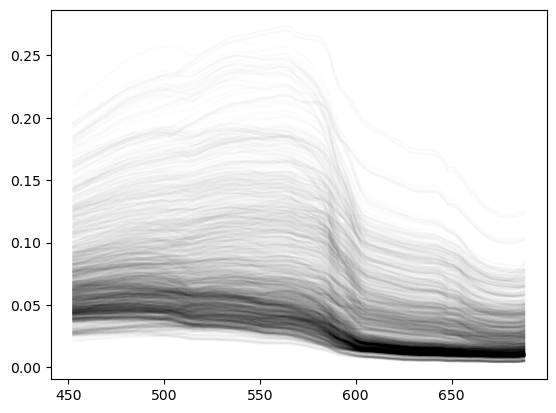

In [212]:
prism_spectra = spectrum_utils.crop_spectra_to_range(spectrum_utils.load_spectra(), [min(wvs), max(wvs)])
plt.plot(wvs, prism_spectra.values.T, color='k', alpha=0.01);
# spectra.loc[min(wvs):max(wvs)]


i = 582

sensor_range = [450, 690]

AOP_model = spectrum_utils.load_aop_model(aop_group_num=1).loc[sensor_range[0]:sensor_range[1]]
wvs = AOP_model.index
AOP_sub = AOP_model.loc[wvs]
AOP_args = (AOP_sub.bb_m.values, AOP_sub.bb_c.values, AOP_sub.Kd_m.values, AOP_sub.Kd_c.values)

# read in spectral library
f = file_ops.RESOURCES_DIR_FP / "spectral_library_clean_v3_PRISM_wavebands.csv"
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)

three_em_cats = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass', 'algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

three_endmembers = {}
for cat in three_em_cats:
    ind = df.index.isin(three_em_cats[cat])
    # select all spectra in category and calculate mean spectrum
    three_endmembers[cat] = df.loc[ind].mean(axis=0).loc[sensor_range[0]:sensor_range[1]]
# create array of average spectrum for each category
three_endmember_array = np.array([spectrum.values for spectrum in three_endmembers.values()])

endmember_array = three_endmember_array
endmember_cats = three_em_cats

fit = fits.iloc[i,:3+len(endmember_array)]
true_spectrum = prism_spectra.iloc[i,:]
# plot problem fits
plotting.plot_single_fit(fit, true_spectrum, AOP_args, endmember_array, endmember_cats.keys())

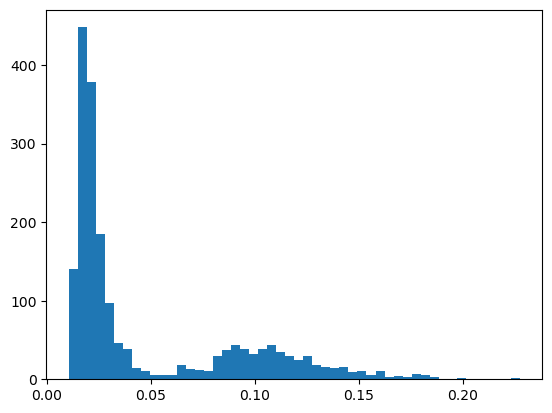

In [15]:
# plot r2
plt.hist(test_fits.spectral_angle, bins=50);

In [ ]:
out, _ = spectrum_utils.spread_simulate_spectra(wvs, three_endmember_array, AOP_args, N=200, Rb_vals=(0.4, 0.4, 0.2))
plt.plot(out.reshape(-1, out.shape[-1]).T, color='k', alpha=0.01);

In [ ]:
glob_cfg, run_cfg = file_ops.instantiate_single_configs_instance(run_ind = 0)

pipe = optimisation_pipeline.OptPipe(glob_cfg, run_cfg)
pipe.run()

# Manual fitting analysis

In [45]:
# SETUP
prism_spectra = spectrum_utils.crop_spectra_to_range(spectrum_utils.load_spectra(), [min(wvs), max(wvs)])
# plt.plot(wvs, prism_spectra.values.T, color='k', alpha=0.01);

AOP_model = spectrum_utils.load_aop_model(aop_group_num=1).loc[sensor_range[0]:sensor_range[1]]
wvs = AOP_model.index
AOP_sub = AOP_model.loc[wvs]
AOP_args = (AOP_sub.bb_m.values, AOP_sub.bb_c.values, AOP_sub.Kd_m.values, AOP_sub.Kd_c.values)

# read in spectral library
f = file_ops.RESOURCES_DIR_FP / "spectral_library_clean_v3_PRISM_wavebands.csv"
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)

# GENERATE ENDMEMBERS
glob_cfg = file_ops.GlobalOptPipeConfig(file_ops.read_yaml(file_ops.CONFIG_DIR_FP / "glob_cfg.yaml"))
sensor_range = [450, 690]

endmember_class_schema = "three_endmember"
endmember_df = optimisation_pipeline.GenerateEndmembers(
    endmember_class_map = glob_cfg.endmember_schema[endmember_class_schema],
    endmember_dimensionality_reduction = "mean",
    endmember_normalisation = False
).generate_endmembers()
endmember_df = spectrum_utils.crop_spectra_to_range(endmember_df, sensor_range)
endmember_array = endmember_df.values

# generate simulated data
sim_spectra, sim_metadata = spectrum_utils.spread_simulate_spectra(wvs, three_endmember_array, AOP_args, N=200, Rb_vals=(0.4, 0.4, 0.2))

NameError: name 'sensor_range' is not defined

In [213]:
sim_spectra

wl,452.642775,455.475056,458.307394,461.139788,463.972238,466.804744,469.637306,472.469925,475.302600,478.135331,...,662.383497,665.219940,668.056439,670.892995,673.729607,676.566275,679.402999,682.239779,685.076616,687.913509
0,0.035411,0.035753,0.036006,0.036272,0.036626,0.037114,0.037709,0.038344,0.038953,0.039493,...,0.060968,0.056968,0.053811,0.051758,0.050861,0.051115,0.052682,0.056022,0.061857,0.070928
1,0.035417,0.035759,0.036011,0.036277,0.036631,0.037118,0.037713,0.038347,0.038954,0.039491,...,0.059736,0.055795,0.052685,0.050659,0.049769,0.050006,0.051521,0.054759,0.060421,0.069219
2,0.035423,0.035764,0.036016,0.036282,0.036636,0.037122,0.037716,0.038349,0.038954,0.039490,...,0.058530,0.054647,0.051583,0.049585,0.048702,0.048921,0.050386,0.053526,0.059019,0.067552
3,0.035430,0.035770,0.036021,0.036287,0.036641,0.037127,0.037721,0.038352,0.038956,0.039490,...,0.057348,0.053523,0.050506,0.048534,0.047658,0.047861,0.049278,0.052322,0.057651,0.065926
4,0.035436,0.035776,0.036027,0.036293,0.036646,0.037132,0.037725,0.038356,0.038957,0.039489,...,0.056192,0.052424,0.049452,0.047507,0.046638,0.046825,0.048195,0.051146,0.056315,0.064341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.039548,0.039885,0.040187,0.040545,0.040956,0.041418,0.041925,0.042387,0.042726,0.042992,...,0.006466,0.006234,0.006046,0.005896,0.005791,0.005708,0.005622,0.005513,0.005382,0.005232
196,0.039575,0.039912,0.040215,0.040575,0.040985,0.041448,0.041955,0.042416,0.042754,0.043020,...,0.006466,0.006235,0.006048,0.005900,0.005795,0.005712,0.005626,0.005516,0.005385,0.005235
197,0.039602,0.039940,0.040244,0.040604,0.041015,0.041478,0.041985,0.042446,0.042783,0.043049,...,0.006466,0.006237,0.006051,0.005903,0.005799,0.005717,0.005630,0.005520,0.005389,0.005237
198,0.039629,0.039967,0.040272,0.040633,0.041045,0.041508,0.042015,0.042475,0.042812,0.043077,...,0.006466,0.006239,0.006054,0.005907,0.005803,0.005721,0.005634,0.005524,0.005392,0.005241


In [44]:
# for a given validation spectrum, minimise with respect to various objective functions
i = 6
obs_spectra = prism_spectra

# depth_bounds = (1,2)
depth_bounds = (0,50)

of = spectrum_utils.sa_objective_unity_fn
# minimise
endmember_bounds = (0, 1)
fit = minimize(
            of,
            # initial parameter values
            x0=[0.1, 0.1, 0] + [0.0001] * len(endmember_array),
            # extra arguments passsed to the object function (and its derivatives)
            args=(obs_spectra.loc[i], # spectrum to fit (obs)
                  *AOP_args,    # wavelength-dependent backscatter and attenuation coefficients (bb_m, bb_c, Kd_m, Kd_c)
                  endmember_array  # typical end-member spectra
                  ),
            # constrain values
            bounds=[(0, 0.41123), (0.01688, 3.17231), depth_bounds] + [endmember_bounds] * len(endmember_array), # may not always want to constrain this (e.g. for PCs)
            method="L-BFGS-B",
            tol=1e-15
            )

true_spectrum = obs_spectra.iloc[i,:]
# cast to same format as saved
fit = pd.Series(fit.x[:])

plotting.plot_single_fit(fit, true_spectrum, AOP_args, endmember_array, endmember_df.index)
print(fit)
print("sum of endmember contribution:", sum(fit[3:]))

NameError: name 'endmember_array' is not defined

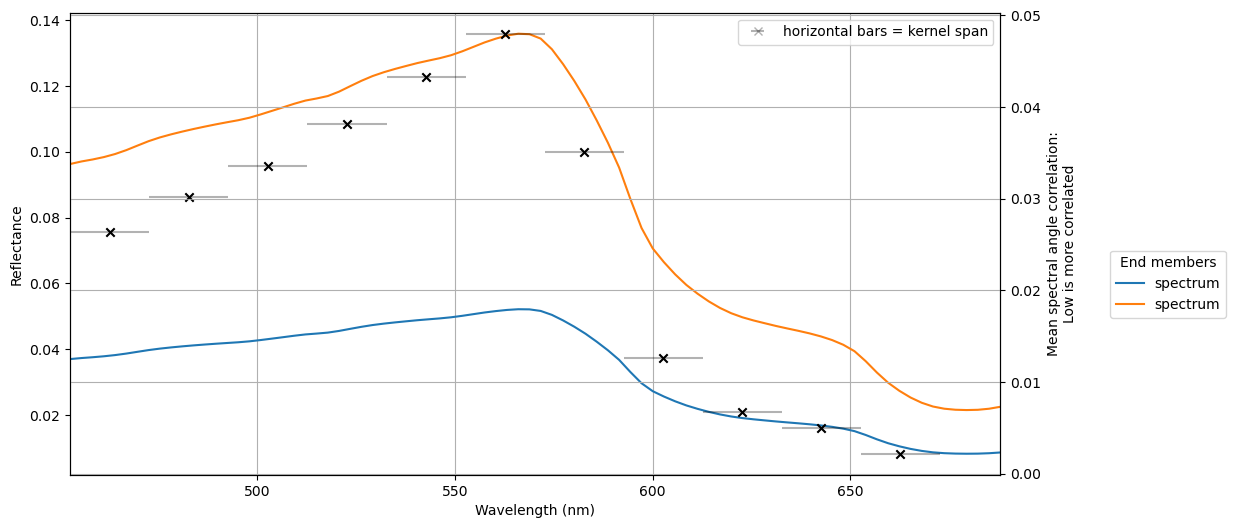

In [279]:
# highlight discrepensies wrt an objective function
kernel_width = 20
kernel_displacement = 20
wvs = true_spectrum.index

fit_spectrum = spectrum_utils.generate_spectrum(fit, wvs, endmember_array, AOP_args)
# combine the observed and fitted spectra in a numpy array
comp_spectra = np.array([true_spectrum.values, fit_spectrum])
metric = spectrum_utils.calc_ssq

wv_pairs, mean_corrs = spectrum_utils.calc_rolling_similarity(wvs, comp_spectra, kernel_width, kernel_displacement, metric)

plotting.plot_rolling_spectral_similarity(wv_pairs, mean_corrs, wvs, comp_spectra)

# Pipeline automation

In [5]:
config_params_dict = {
    'processing': {
        'aop_group_num': [1, 2, 3],
        'nir_wavelengths': [[750, 1100]],
        'sensor_range': [[450, 690]],
        'endmember_dimensionality_reduction': ["mean", "median", "pca", "nmf", "ica", "svd"],
        'endmember_normalisation': ["minmax", "zscore", "robust", "maxabs"],
        'endmember_class_schema': ["four_endmember", "all", "inorganic_organic"],
        'spectra_normalisation': ["minmax", "zscore", "robust", "maxabs"]
    },
    "simulation": {
        "type": ["spread"],
        "N": [100],
        "Rb_vals": [(0,1)],
        "n_depths": [10],
        "depth_lims": [(0, 10)],
        "n_ks": [10],
        "k_lims": [(0, 0.4)],
        "n_bbs": [10],
        "bb_lims": [(0.01, 0.03)],
        "n_noise_levels": [10],
        "noise_lims": [(0.001, 0)],
        "noise_ind": [0] 
    },
    'fitting': {
        'objective_fn': ["r2", "spectral_angle"],
        'bb_bounds': [(0, 0.41123), (0, 0.2)],
        'Kd_bounds': [(0.01688, 3.17231), (0.01688, 1.5)],
        'H_bounds': [(0, 10), (0, 40), 
                    #  (0, 20), (0, 30)
                     ],
        'solver': ['L-BFGS-B'], 
        # 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov'],
        'tol': [
            # 0.0, 1e-3, 
            1e-6, 1e-9]
    }
}


run_cfgs = file_ops.generate_config_dicts(config_params_dict)
glob_cfg = file_ops.read_yaml(file_ops.CONFIG_DIR_FP / "glob_cfg.yaml")
exec_kwargs = {
    "tqdm": False,
    "n_cpus": 128
}

In [ ]:
run_cfgs[0]

In [ ]:
optimisation_pipeline.run_pipeline(glob_cfg, run_cfgs[:3])